# Estimating COVID-19's $R_t$ with Rainier (ported from PYMC)

Grzegorz Kossakowski & Maciek Zdanowicz - May 5 (beta)

Model originally built by [Kevin Systrom](https://twitter.com/kevin) in `Realtime Rt mcmc.ipynb` notebook, ported to [Rainier](https://rainier.fit) with lots of help from [Avi Bryant](https://twitter.com/avibryant). Model comparison for European countries is in `Realtime Rt plots only.ipynb`.

This notebook requires [Almond](https://almond.sh) to run.

It's a work in progress.

In [86]:
import $ivy.`com.stripe::rainier-core:0.3.3`
import $ivy.`com.stripe::rainier-notebook:0.3.3`

import $ivy.$                               

import $ivy.$                                   

In [87]:
import com.stripe.rainier.compute._
import com.stripe.rainier.core._
import com.stripe.rainier.sampler._
import com.stripe.rainier.notebook._

import com.stripe.rainier.compute._

import com.stripe.rainier.core._

import com.stripe.rainier.sampler._

import com.stripe.rainier.notebook._

In [88]:
PPrint.register(repl)

In [89]:
import $ivy.`com.github.tototoshi::scala-csv:1.3.6`
import com.github.tototoshi.csv._
import java.io.File
import scala.util.Try

import $ivy.$                                      

import com.github.tototoshi.csv._

import java.io.File

import scala.util.Try

In [90]:
def time[R](block: => R): R = {
    val t0 = System.nanoTime()
    val result = block    // call-by-name
    val t1 = System.nanoTime()
    val timeMilis = ((t1 - t0) / 1e6).toInt
    println(s"Elapsed time: $timeMilis ms")
    result
}

defined function time

In [91]:
val countriesOnsetData = {
    val csvReader = CSVReader.open(new File("data/onset.csv"))
    val xs = csvReader.allWithHeaders()
    csvReader.close()
    xs
}

countriesOnsetData: List[Map[String, String]] = List(
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-06",
    "Onset" -> "1.180164888457808"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-07",
    "Onset" -> "1.236663433559651"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-08",
    "Onset" -> "1.6939864209505335"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-09",
    "Onset" -> "1.9956353055286131"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-10",
    "Onset" -> "2.630455868089234"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-11",
    "Onset" -> "2.842386032977692"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-12",
    "Onset" -> "3.0227934044616878"
  ),
  Map(
    "country" -> "Austria",
    "date" -> "2020-02-13",
...

In [92]:
import java.time.LocalDate
import java.time.chrono.ChronoLocalDate
// so comparisons work like max()
import scala.math.Ordering.Implicits._

def toDate(s: String): LocalDate =
    LocalDate.parse(s)

// we need to specify type parameter ChronoLocalDate (a super type of LocalDate) because
// that's what the comparison is defined for
countriesOnsetData.map(entry => toDate(entry("date"))).max[ChronoLocalDate]

import java.time.LocalDate

import java.time.chrono.ChronoLocalDate
// so comparisons work like max()

import scala.math.Ordering.Implicits._


defined function toDate
res91_4: LocalDate = 2020-06-01

In [93]:
val pdelayData = {
    val csvReader = CSVReader.open(new File("data/pdelay.csv"))
    val xs = csvReader.allWithHeaders()
    csvReader.close()
    xs
}

pdelayData: List[Map[String, String]] = List(
  Map("index" -> "0", "pdelay" -> "0.006547041707080504"),
  Map("index" -> "1", "pdelay" -> "0.04194956353055286"),
  Map("index" -> "2", "pdelay" -> "0.05771096023278371"),
  Map("index" -> "3", "pdelay" -> "0.06983511154219205"),
  Map("index" -> "4", "pdelay" -> "0.07153249272550921"),
  Map("index" -> "5", "pdelay" -> "0.08583899127061105"),
  Map("index" -> "6", "pdelay" -> "0.07953443258971872"),
  Map("index" -> "7", "pdelay" -> "0.07516973811833172"),
  Map("index" -> "8", "pdelay" -> "0.07710960232783705"),
  Map("index" -> "9", "pdelay" -> "0.07904946653734239"),
  Map("index" -> "10", "pdelay" -> "0.06304558680892337"),
  Map("index" -> "11", "pdelay" -> "0.0511639185257032"),
  Map("index" -> "12", "pdelay" -> "0.04485935984481086"),
  Map("index" -> "13", "pdelay" -> "0.038554801163918524"),
  Map("index" -> "14", "pdelay" -> "0.028855480116391854"),
  Map("index" -> "15", "pdelay" -> "0.026430649854510185"),
  Map("index" -> 

In [94]:
val pdelay = pdelayData.collect { case m => m("pdelay").toDouble }

pdelay: List[Double] = List(
  0.006547041707080504,
  0.04194956353055286,
  0.05771096023278371,
  0.06983511154219205,
  0.07153249272550921,
  0.08583899127061105,
  0.07953443258971872,
  0.07516973811833172,
  0.07710960232783705,
  0.07904946653734239,
  0.06304558680892337,
  0.0511639185257032,
  0.04485935984481086,
  0.038554801163918524,
  0.028855480116391854,
  0.026430649854510185,
  0.01915615906886518,
  0.02061105722599418,
  0.011881668283220174,
  0.009456838021338506,
  0.009699321047526674,
  0.006547041707080504,
  0.004122211445198836,
  0.0036372453928225023,
  0.002909796314258002,
  0.0036372453928225023,
  0.0019398642095053346,
  4.8496605237633366E-4,
  4.8496605237633366E-4,
  0.0,
  9.699321047526673E-4,
  2.4248302618816683E-4,
  4.8496605237633366E-4,
  7.274490785645005E-4,
  0.001454898157129001,
  2.4248302618816683E-4,
  4.8496605237633366E-4,
  7.274490785645005E-4,
...

In [95]:
def prepareDataForModel(xs: List[Long], pd: List[Double]): List[(Long,Double)] = {
    val cpd = pd.scanLeft(0.0)(_+_).tail
    val cpdPadded = List.fill(xs.size - pd.size)(1.0) ++ cpd.reverse
    // ensure that case numbers are always at least 1 so we avoid numerical issues involving 0
    // adding 1 across all counts doesn't change inputs in any material way
    // see the comment of `predictRt` method for the rationale
    xs.zip(cpdPadded)
}

defined function prepareDataForModel

Preparation of the other model

In [118]:
val samplerConfig = new DefaultConfig {
    override def massMatrixTuner() = new IdentityMassMatrixTuner
    override def sampler() = new HMCSampler(100)
    override val iterations = 100
    override val warmupIterations = 200
}

samplerConfig: DefaultConfig{def massMatrixTuner(): com.stripe.rainier.sampler.IdentityMassMatrixTuner;def sampler(): com.stripe.rainier.sampler.HMCSampler} = ammonite.$sess.cmd117$Helper$$anon$1@373b8f97

Define a function that we'll use to retry the call to Rainier's `predict` that fails occassionally. Fortunately, the failure can be easily detected and 1-2 retries solves the issue.

In [120]:
def argmin[N](seq: Seq[N])(implicit num: Numeric[N]): Int = seq.indexOf(seq.min)

argmin(List(-20,12,3,5,-25,4,5,6,7,-9,-10))

defined function argmin
res119_1: Int = 4

In [121]:
import scala.collection.mutable.ArrayBuffer

/* Retry returns a value and a list of logs produced during consecutive attempts */
def retry[T](maxAttempts: Int, isSuccessful: T => (Boolean, Double)) (f: => T): (T, List[Double]) = {
    var i = 0
    var flag = false
    val logListBuf = ArrayBuffer.empty[Double]
    val resListBuf = ArrayBuffer.empty[T]
    do {
        i = i + 1
        val res = f
        resListBuf += res
        val (resBool, log) = isSuccessful(res)
        logListBuf += log
        val errorMsg = if(resBool) s"Success in [$i] iteration." else s"WARN: Attempt[$i] failed. Retrying..."
        println(errorMsg)
        flag = resBool
    } while (i < maxAttempts && !flag)
    val logList = logListBuf.toList
    return (resListBuf(argmin(logList)), logList)
}

import scala.collection.mutable.ArrayBuffer

/* Retry returns a value and a list of logs produced during consecutive attempts */

defined function retry

In [122]:
import scala.util.Random

def isSuccess(x: Int) = {
    val num = Random.nextInt(10)
    (num < 2,Random.nextDouble())
}

retry(maxAttempts = 10, isSuccess) { 
    val value = Random.nextInt(1000)
    println(value)
    value
}

230
WARN: Attempt[1] failed. Retrying...
374
WARN: Attempt[2] failed. Retrying...
987
WARN: Attempt[3] failed. Retrying...
31
WARN: Attempt[4] failed. Retrying...
625
WARN: Attempt[5] failed. Retrying...
242
WARN: Attempt[6] failed. Retrying...
1
Success in [7] iteration.


import scala.util.Random


defined function isSuccess
res121_2: (Int, List[Double]) = (
  987,
  List(
    0.9757837086320961,
    0.6264484443803771,
    0.26020944415281066,
    0.7277811744196854,
    0.7571289807141701,
    0.3886180407281936,
    0.516365354819387
  )
)

Fixed the parameters for all distributions

In [123]:
case class RtModelEstimates(rts: Vec[Real], 
                            rtsEstimates: List[Seq[Double]], 
                            serialInterval: Real, 
                            serialIntervalEstimates: Seq[Double])

defined class RtModelEstimates

In [124]:
def predictRtOnsetLogProcess(onsetNumbers: List[Long], pdelay: List[Double]): (Vec[Real], List[Seq[Double]]) = {
    
    val data = prepareDataForModel(onsetNumbers, pdelay)
    
    val (model, rts) =  {
        val (onset, cum_pdelay) = data.unzip
        val serialInterval = Gamma(46.0,10.0).latent
        val logR0 = Normal(0, 1).latent
        val sigma = Exponential(10).latent
        val diffs = Laplace(0,sigma).latentVec(data.size)
        val logRts = Vec.from(diffs.toList.scanLeft(logR0)(_ + _))
        val inferredYesterday = data.take(data.size-1).map { case (o_t, cp_t) => 
            o_t/cp_t 
        }.zipWithIndex
        val expectedToday = Vec.from(inferredYesterday.zip(cum_pdelay.drop(1))).map { case ((infYest, i), cpd) =>
            val lambda = infYest*cpd*((logRts(i).exp - 1)/serialInterval).exp
            Poisson(lambda)
        }
        (Model.observe(onset.drop(1), expectedToday), logRts.map(_.exp))
    }
    
    def detectFailedRun(trace: Trace): (Boolean, Double) = {
        // from: https://twitter.com/avibryant/status/1253049509128499201
        val stat = trace.diagnostics.map(_.rHat).max
        (stat < 1.1, stat)
    }
    
    val (trace, log) = retry(maxAttempts = 3, isSuccessful = detectFailedRun) {
        model.sample(samplerConfig, 4)
    }
    
    rts -> trace.predict(rts)
}

defined function predictRtOnsetLogProcess

In [125]:
// direct (and faithful) translation of Systrom's MCMC model from
// Realtime Rt mcmc.ipynb up to different handling of this line
// mu = pm.math.maximum(.1, expected_today)
// my is the lambda of Poisson distribution that must be > 0.
// Kevin's solution is to take max(0.1, expected_today) to ensure
// that lambda > 0. However, `expected_today` is dependent only on input data and is not
// part of the model so we can ensure it's > 0 by fixing up the input data of the model.
// this is done in `prepareDataForModel`
def predictRt(onsetNumbers: List[Long], pdelay: List[Double], failedRunDetection: Boolean = true): (RtModelEstimates, List[Double]) = {
    
    val data = prepareDataForModel(onsetNumbers, pdelay)
    
    val (model, rts, serialInterval) = {
        val (onset, cum_pdelay) = data.unzip
        val serialInterval = Gamma(46.0,1/10.0).latent
        val sigma = Normal(0,0.03).latent.abs
        val Theta0 = Normal(0.1,0.1).latent
        val diffs = Laplace(0,sigma).latentVec(data.size) // Maybe normal would be better
        val ThetaT = Vec.from(diffs.toList.scanLeft(Theta0)(_ + _))
        val Rts = ThetaT.map(_*serialInterval + 1)
        val inferredYesterday = data.take(data.size-1).map { case (o_t, cp_t) => 
            o_t/cp_t 
        }.zipWithIndex
        val expectedToday = Vec.from(inferredYesterday.zip(cum_pdelay.drop(1))).map { case ((infYest, i), cpd) =>
            val lambda = Real(0.1).max(infYest * cpd * (ThetaT(i).exp))
            Poisson(lambda)
        }
        
        val obsModel = Model.observe(onset.drop(1), expectedToday)
        val trackSerialInterval = Model.track(Set(serialInterval))
        (obsModel.merge(trackSerialInterval), Rts, serialInterval)
    }
    
    def detectFailedRun(trace: Trace): (Boolean, Double) = {
        // from: https://twitter.com/avibryant/status/1253049509128499201
        val stat = trace.diagnostics.map(_.rHat).max
        val cond = !failedRunDetection || stat < 1.1
        (cond, stat)
    }
    
    val (trace, log) = retry(maxAttempts = 3, isSuccessful = detectFailedRun) {
        model.sample(samplerConfig, 2)
    }

    val rtme = RtModelEstimates(rts = rts, 
                 rtsEstimates = trace.predict(rts),
                 serialInterval = serialInterval,
                 serialIntervalEstimates = trace.predict(serialInterval))
    (rtme, log)
}

defined function predictRt

In [126]:
def median[N](seq: Seq[N])(implicit num: Numeric[N]): Double = {
    val l = (seq.map { n =>
      num.toDouble(n)
    }).sorted
    val n = l.size
    if(n % 2 == 1)
        l(n/2)
    else
        (l(n/2) + l(n/2-1))/2
}

defined function median

In [127]:
case class RtsDistributionStats(means: Seq[(Int, Double)], 
                                medians: Seq[(Int, Double)],
                                hdpis_90: Seq[(Int, (Double, Double))], 
                                hdpis_50: Seq[(Int, (Double, Double))])
def distributionStats(rts: Vec[Real], rtForecasts: List[Seq[Double]]): RtsDistributionStats = {
    val means = 0.until(rts.size).map{i => (i,mean(rtForecasts.map(_(i))))}
    val medians = 0.until(rts.size).map{i => (i,median(rtForecasts.map(_(i))))}
    val hdpis_90 = 0.until(rts.size).map{i => (i,hdpi(rtForecasts.map(_(i)),0.9))}
    val hdpis_50 = 0.until(rts.size).map{i => (i,hdpi(rtForecasts.map(_(i)),0.5))}
    RtsDistributionStats(means, medians, hdpis_90, hdpis_50)
}

defined class RtsDistributionStats
defined function distributionStats

In [128]:
val countryLogs = scala.collection.mutable.Map[String, List[Double]]()

def processLogs(country: String, logs: List[Double]) = {
    countryLogs(country) = logs
}

countryLogs: collection.mutable.Map[String, List[Double]] = Map()
defined function processLogs

Chain 1 Complete : Iteration: 100 (42ms) Acceptance rate: 0.92 E-BFMI: 0.92 Step size: 0.002 Total gradient evaluations: 2e+04 (188us) Total time: 13s

Chain 2 Complete : Iteration: 100 (40ms) Acceptance rate: 0.94 E-BFMI: 1.08 Step size: 0.003 Total gradient evaluations: 2e+04 (188us) Total time: 12s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 100 (39ms) Acceptance rate: 0.93 E-BFMI: 1.57 Step size: 0.003 Total gradient evaluations: 2e+04 (190us) Total time: 12s

Chain 2 Complete : Iteration: 100 (39ms) Acceptance rate: 0.72 E-BFMI: 1.60 Step size: 0.003 Total gradient evaluations: 2e+04 (183us) Total time: 11s

WARN: Attempt[2] failed. Retrying...


Chain 1 Complete : Iteration: 100 (48ms) Acceptance rate: 0.69 E-BFMI: 1.02 Step size: 0.004 Total gradient evaluations: 2e+04 (343us) Total time: 13s

Chain 2 Complete : Iteration: 100 (40ms) Acceptance rate: 0.88 E-BFMI: 1.48 Step size: 0.003 Total gradient evaluations: 2e+04 (200us) Total time: 12s

WARN: Attempt[3] failed. Retrying...
Elapsed time: 78383 ms


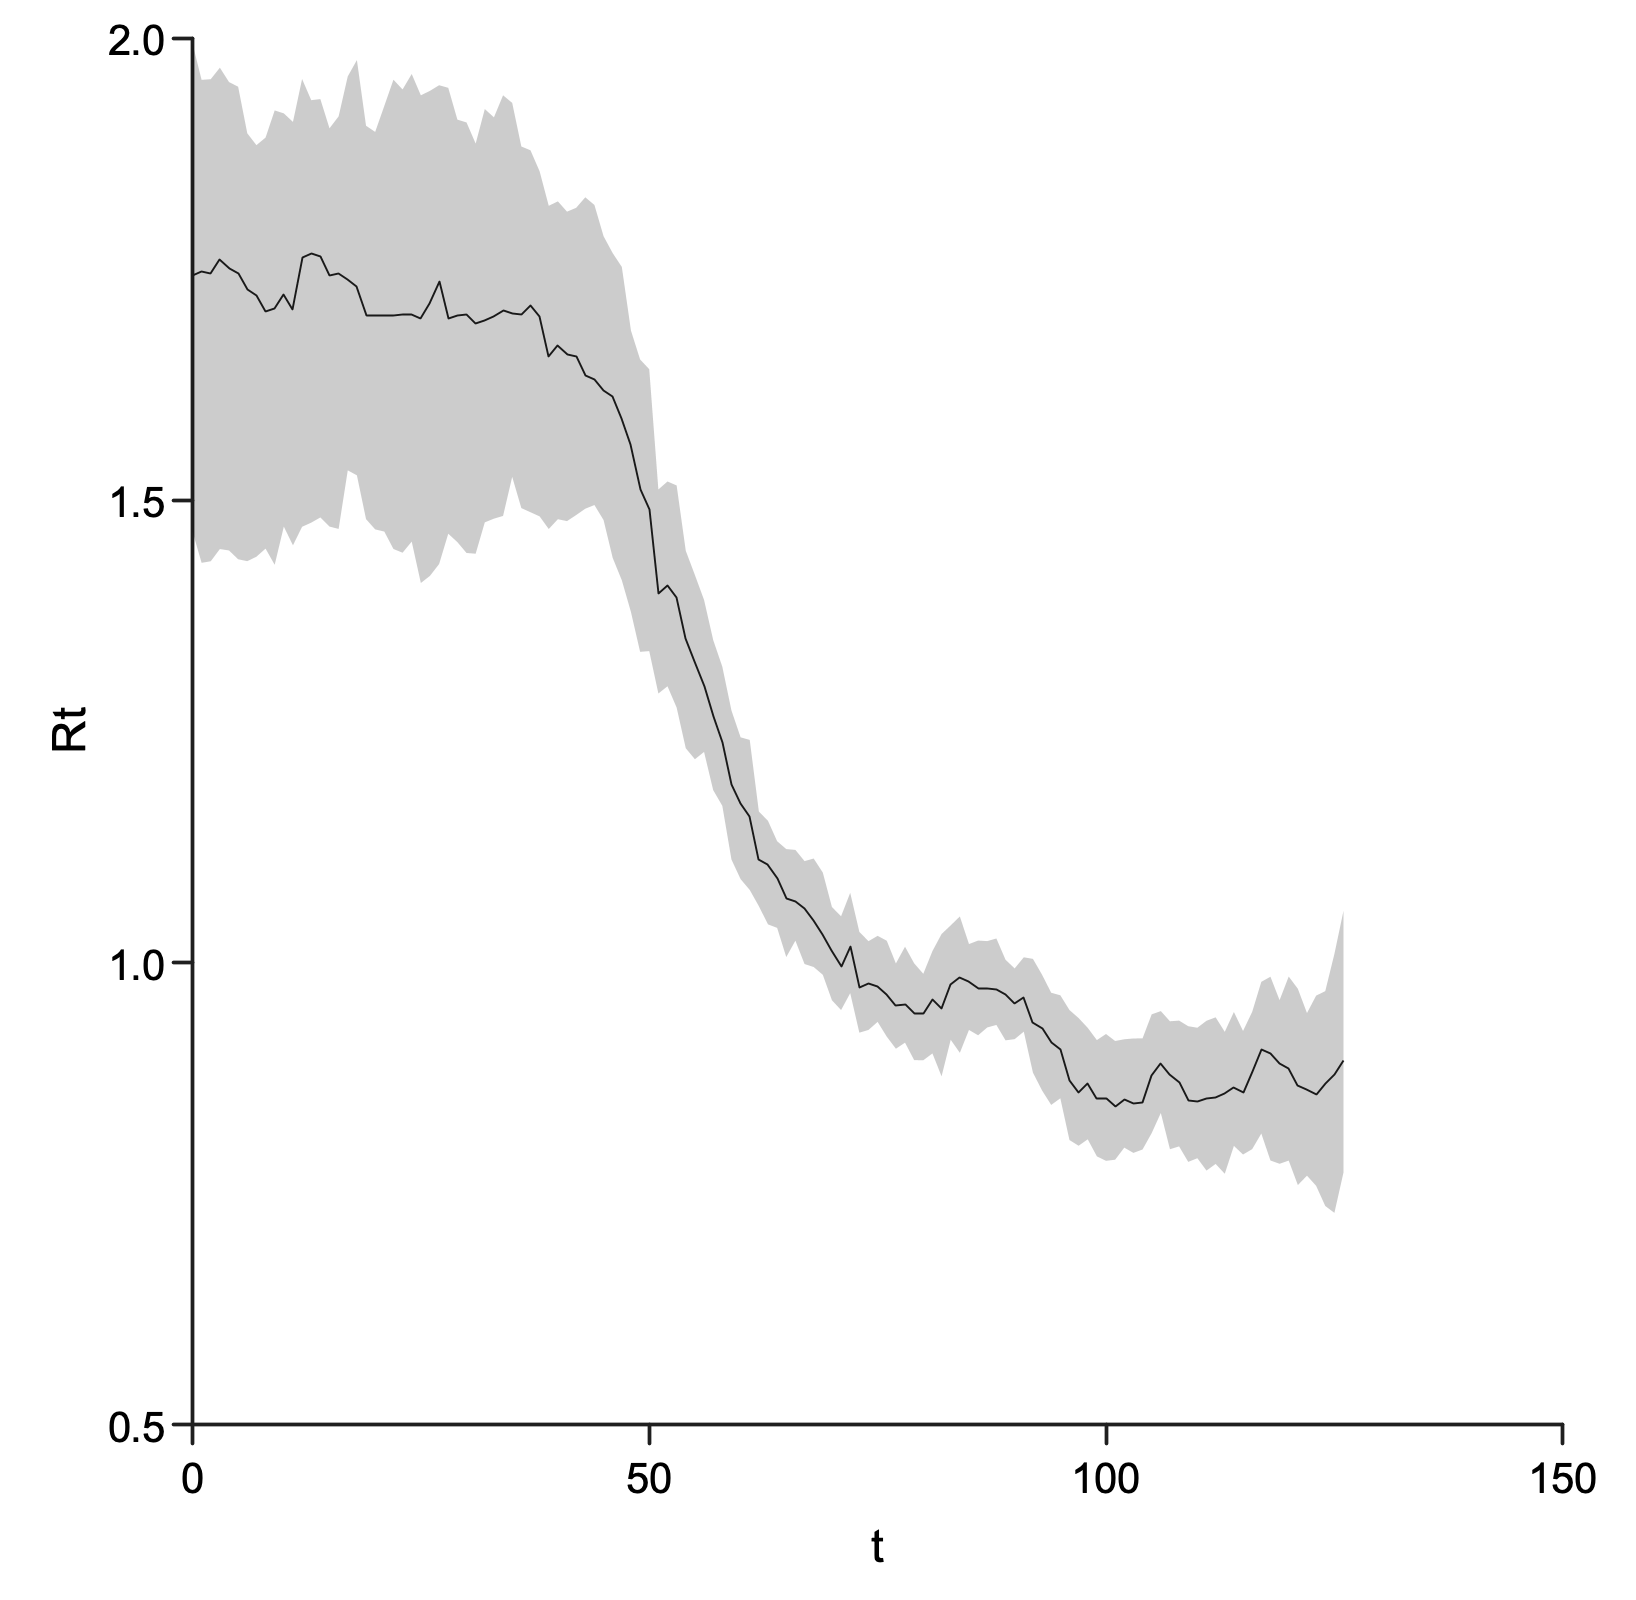

In [129]:
{{
    val countryName = "United_Kingdom"
    val onsetNumbers = countriesOnsetData.collect {
        case m if m("country") == countryName => m("Onset").toDouble.round
    }
    val RtModelEstimates(rts,estimates,_, _) = time { 
        val (res, log) = predictRt(onsetNumbers, pdelay, failedRunDetection = true)
        processLogs(countryName, log)
        res
    }
    val RtsDistributionStats(means, medians, hdpis_90, hdpis_50) = distributionStats(rts, estimates)
    // show("t", "Rt", line(means), shade(hdpis_50))
    show("t", "Rt", line(means), shade(hdpis_90))
}}

In [130]:
countryLogs

res129: collection.mutable.Map[String, List[Double]] = Map(
  "United_Kingdom" -> List(4.036200524870752, 5.938226637677339, 3.7662111040647)
)

In [131]:
val countriesToPredict = Seq("Poland", "France", "Italy") // Smaller set
// val countriesToPredict = countriesOnsetData.map(_("country")).toSet  // Full set

countriesToPredict: Seq[String] = List("Poland", "France", "Italy")

In [132]:
val countryStats: Map[String, Either[Throwable, RtsDistributionStats]] = {
    assert(countriesToPredict.toSet.subsetOf(countriesOnsetData.map(_("country")).toSet))
    val allStats = time {
        countriesToPredict.par.map { countryName =>
            val caseNumbers = countriesOnsetData.collect {
                case m if m("country") == countryName => m("Onset").toDouble.round
            }
            val possiblyFailed: Try[RtsDistributionStats] = Try { 
                val (rtme, logs) = predictRt(caseNumbers, pdelay, failedRunDetection = true)
                processLogs(countryName, logs)
                val RtModelEstimates(rts,estimates, serialInterval, serialEstimates) = rtme
                val stats@RtsDistributionStats(means, medians, hdpis_90, hdpis_50) = distributionStats(rts, estimates)
                println(s"$countryName [done]")
                stats
            }
            countryName -> possiblyFailed.toEither
        }.seq
    }
    allStats.toMap
}

Chain 1 Complete : Iteration: 100 (48ms) Acceptance rate: 0.91 E-BFMI: 0.75 Step size: 0.01 Total gradient evaluations: 2e+04 (228us) Total time: 18s

Chain 1 Complete : Iteration: 100 (83ms) Acceptance rate: 0.93 E-BFMI: 0.75 Step size: 0.004 Total gradient evaluations: 2e+04 (349us) Total time: 30s

Chain 1 Complete : Iteration: 100 (109ms) Acceptance rate: 0.93 E-BFMI: 1.05 Step size: 0.003 Total gradient evaluations: 2e+04 (1ms) Total time: 37s

Chain 2 Complete : Iteration: 100 (48ms) Acceptance rate: 0.93 E-BFMI: 0.99 Step size: 0.01 Total gradient evaluations: 2e+04 (166us) Total time: 14s

Chain 2 Complete : Iteration: 100 (87ms) Acceptance rate: 0.95 E-BFMI: 0.84 Step size: 0.004 Total gradient evaluations: 2e+04 (413us) Total time: 25s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 100 (47ms) Acceptance rate: 0.83 E-BFMI: 0.98 Step size: 0.01 Total gradient evaluations: 2e+04 (206us) Total time: 14s

Chain 2 Complete : Iteration: 100 (122ms) Acceptance rate: 0.80 E-BFMI: 0.01 Step size: 5e-06 Total gradient evaluations: 2e+04 (596us) Total time: 34s

Chain 2 Complete : Iteration: 100 (50ms) Acceptance rate: 0.91 E-BFMI: 1.16 Step size: 0.01 Total gradient evaluations: 2e+04 (181us) Total time: 15s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 100 (80ms) Acceptance rate: 0.92 E-BFMI: 1.10 Step size: 0.005 Total gradient evaluations: 2e+04 (405us) Total time: 27s

WARN: Attempt[2] failed. Retrying...


Chain 1 Complete : Iteration: 100 (46ms) Acceptance rate: 0.94 E-BFMI: 0.97 Step size: 0.01 Total gradient evaluations: 2e+04 (194us) Total time: 16s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 100 (73ms) Acceptance rate: 0.94 E-BFMI: 1.28 Step size: 0.003 Total gradient evaluations: 2e+04 (369us) Total time: 26s

Chain 2 Complete : Iteration: 100 (43ms) Acceptance rate: 0.89 E-BFMI: 0.65 Step size: 0.01 Total gradient evaluations: 2e+04 (196us) Total time: 13s

Chain 2 Complete : Iteration: 100 (56ms) Acceptance rate: 0.93 E-BFMI: 0.72 Step size: 0.004 Total gradient evaluations: 2e+04 (227us) Total time: 18s

WARN: Attempt[3] failed. Retrying...
Poland [done]


Chain 2 Complete : Iteration: 100 (74ms) Acceptance rate: 0.92 E-BFMI: 2.09 Step size: 0.0001 Total gradient evaluations: 2e+04 (709us) Total time: 22s

WARN: Attempt[2] failed. Retrying...


Chain 1 Complete : Iteration: 100 (58ms) Acceptance rate: 0.85 E-BFMI: 1.52 Step size: 0.0004 Total gradient evaluations: 2e+04 (287us) Total time: 16s

Chain 2 Complete : Iteration: 100 (54ms) Acceptance rate: 0.96 E-BFMI: 1.09 Step size: 0.004 Total gradient evaluations: 2e+04 (224us) Total time: 17s

WARN: Attempt[2] failed. Retrying...


Chain 1 Complete : Iteration: 100 (64ms) Acceptance rate: 0.93 E-BFMI: 1.68 Step size: 0.003 Total gradient evaluations: 2e+04 (277us) Total time: 21s

WARN: Attempt[3] failed. Retrying...
France [done]


Chain 2 Complete : Iteration: 100 (60ms) Acceptance rate: 0.97 E-BFMI: 0.77 Step size: 0.003 Total gradient evaluations: 2e+04 (274us) Total time: 18s

WARN: Attempt[3] failed. Retrying...
Italy [done]
Elapsed time: 166883 ms


countryStats: Map[String, Either[Throwable, RtsDistributionStats]] = Map(
  "Poland" -> Right(
    RtsDistributionStats(
      Vector(
        (0, 1.540742129935617),
        (1, 1.5492024768355455),
        (2, 1.53960101704911),
        (3, 1.5231565259912714),
        (4, 1.517111548756694),
        (5, 1.513173556591927),
        (6, 1.511449329828923),
        (7, 1.5271757141759343),
        (8, 1.5151479043101088),
        (9, 1.5230903111416012),
        (10, 1.5128344821721402),
        (11, 1.5131970283292215),
        (12, 1.5210002270170397),
        (13, 1.5108922366501525),
        (14, 1.512680011020172),
        (15, 1.5015132700435259),
        (16, 1.5003745735765712),
        (17, 1.4901662582836572),
        (18, 1.483873388578861),
        (19, 1.4864100966078166),
        (20, 1.49189293152371),
        (21, 1.495433392672734),
        (22, 1.4679285122725585),
        (23, 1.4544927636536167),
        (24, 1.4423544092219098),
        (25, 1.4407259649567472),
  

In [133]:
countryLogs

res132: collection.mutable.Map[String, List[Double]] = Map(
  "United_Kingdom" -> List(4.036200524870752, 5.938226637677339, 3.7662111040647),
  "Italy" -> List(38.5214508651233, 15.617178404697535, 3.4647136853918554),
  "France" -> List(2.59029657668949, 8.15743905671114, 5.484996589334801),
  "Poland" -> List(4.167850772483678, 4.456762744460383, 1.4639273440261256)
)

In [134]:
countryStats

res133: Map[String, Either[Throwable, RtsDistributionStats]] = Map(
  "Poland" -> Right(
    RtsDistributionStats(
      Vector(
        (0, 1.540742129935617),
        (1, 1.5492024768355455),
        (2, 1.53960101704911),
        (3, 1.5231565259912714),
        (4, 1.517111548756694),
        (5, 1.513173556591927),
        (6, 1.511449329828923),
        (7, 1.5271757141759343),
        (8, 1.5151479043101088),
        (9, 1.5230903111416012),
        (10, 1.5128344821721402),
        (11, 1.5131970283292215),
        (12, 1.5210002270170397),
        (13, 1.5108922366501525),
        (14, 1.512680011020172),
        (15, 1.5015132700435259),
        (16, 1.5003745735765712),
        (17, 1.4901662582836572),
        (18, 1.483873388578861),
        (19, 1.4864100966078166),
        (20, 1.49189293152371),
        (21, 1.495433392672734),
        (22, 1.4679285122725585),
        (23, 1.4544927636536167),
        (24, 1.4423544092219098),
        (25, 1.4407259649567472),
        

In [135]:
val failedToConverge = countryStats collect {
    case (countryName, res) if res.isLeft => countryName
} 

failedToConverge: collection.immutable.Iterable[String] = List()

In [136]:
// co
val countriesTriedOneMoreTime = failedToConverge.toSeq map { countryName =>
    println(countryName)
    val onsetNumbers = countriesOnsetData.collect {
        case m if m("country") == countryName => m("Onset").toDouble.round
    }
    val RtModelEstimates(rts,estimates, serialInterval, serialEstimates) = time { 
        val (res, logs) = predictRt(onsetNumbers, pdelay, failedRunDetection = false)
        processLogs(countryName, logs)
        res
    }
    countryName -> distributionStats(rts, estimates)
}

countriesTriedOneMoreTime: Seq[(String, RtsDistributionStats)] = List()

In [137]:
val finalCountryStats = (countryStats collect {
    case (countryName, Right(stats)) => countryName -> stats
})// ++ countriesTriedOneMoreTime

finalCountryStats: Map[String, RtsDistributionStats] = Map(
  "Poland" -> RtsDistributionStats(
    Vector(
      (0, 1.540742129935617),
      (1, 1.5492024768355455),
      (2, 1.53960101704911),
      (3, 1.5231565259912714),
      (4, 1.517111548756694),
      (5, 1.513173556591927),
      (6, 1.511449329828923),
      (7, 1.5271757141759343),
      (8, 1.5151479043101088),
      (9, 1.5230903111416012),
      (10, 1.5128344821721402),
      (11, 1.5131970283292215),
      (12, 1.5210002270170397),
      (13, 1.5108922366501525),
      (14, 1.512680011020172),
      (15, 1.5015132700435259),
      (16, 1.5003745735765712),
      (17, 1.4901662582836572),
      (18, 1.483873388578861),
      (19, 1.4864100966078166),
      (20, 1.49189293152371),
      (21, 1.495433392672734),
      (22, 1.4679285122725585),
      (23, 1.4544927636536167),
      (24, 1.4423544092219098),
      (25, 1.4407259649567472),
      (26, 1.4166448808086443),
      (27, 1.4040555377620647),
      (28, 1.3937

In [138]:
// override the previous variable so the rest of the notebook works fine
val countryStats = finalCountryStats

countryStats: Map[String, RtsDistributionStats] = Map(
  "Poland" -> RtsDistributionStats(
    Vector(
      (0, 1.540742129935617),
      (1, 1.5492024768355455),
      (2, 1.53960101704911),
      (3, 1.5231565259912714),
      (4, 1.517111548756694),
      (5, 1.513173556591927),
      (6, 1.511449329828923),
      (7, 1.5271757141759343),
      (8, 1.5151479043101088),
      (9, 1.5230903111416012),
      (10, 1.5128344821721402),
      (11, 1.5131970283292215),
      (12, 1.5210002270170397),
      (13, 1.5108922366501525),
      (14, 1.512680011020172),
      (15, 1.5015132700435259),
      (16, 1.5003745735765712),
      (17, 1.4901662582836572),
      (18, 1.483873388578861),
      (19, 1.4864100966078166),
      (20, 1.49189293152371),
      (21, 1.495433392672734),
      (22, 1.4679285122725585),
      (23, 1.4544927636536167),
      (24, 1.4423544092219098),
      (25, 1.4407259649567472),
      (26, 1.4166448808086443),
      (27, 1.4040555377620647),
      (28, 1.393723549

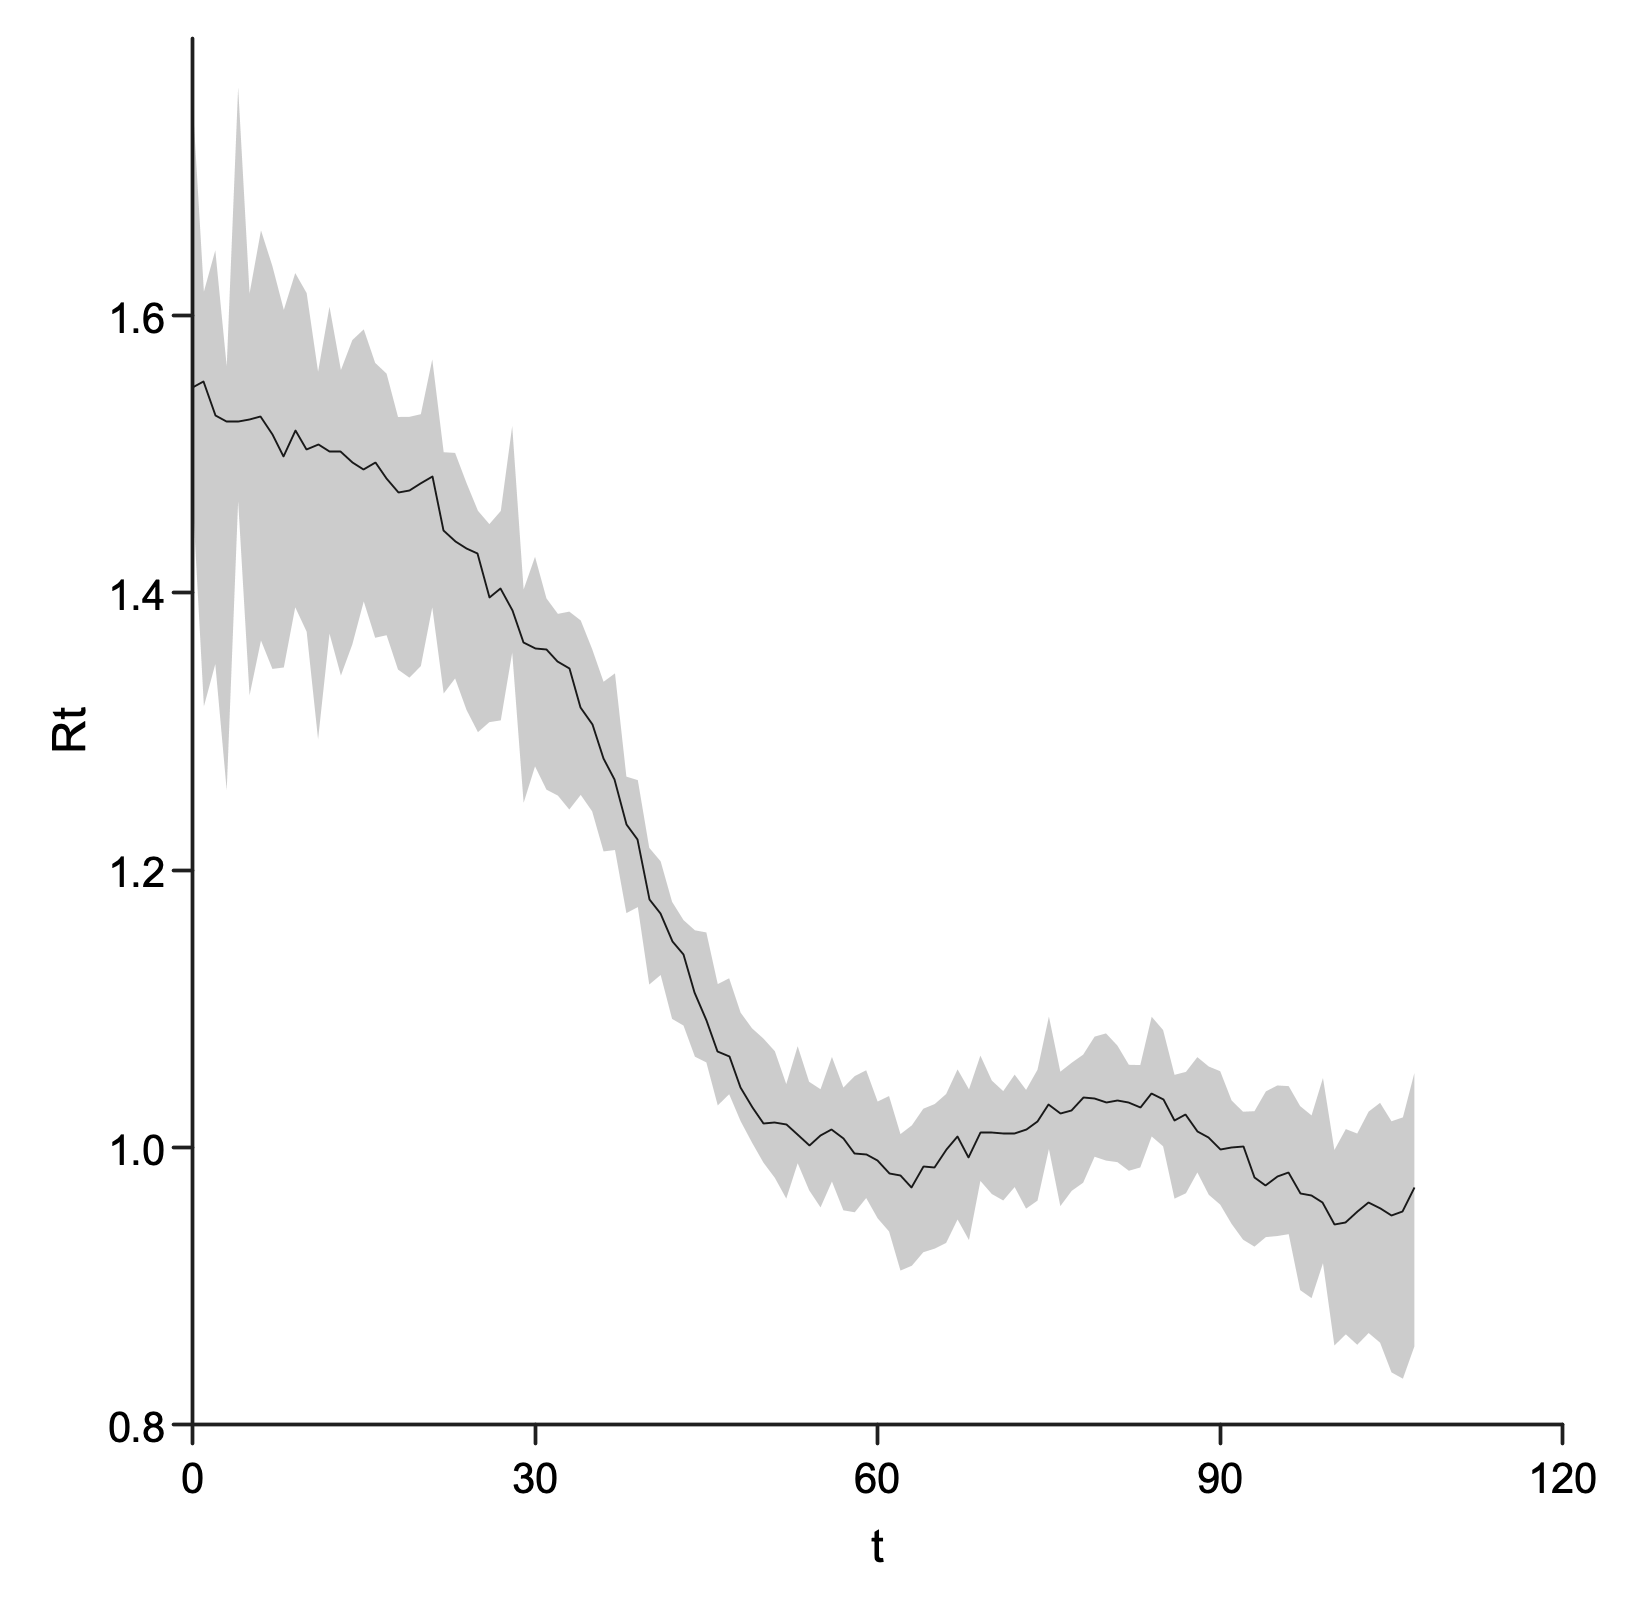

In [139]:
{{
    val RtsDistributionStats(means, medians, hdpis_90, hdpis_50) = countryStats("Poland")
    show("t", "Rt", line(medians), shade(hdpis_50))
}}

## Saving the results

In [140]:
def datesForCountry(country: String) = {
    countriesOnsetData.collect {
        case m if m("country") == country => m("date")
    }
}

defined function datesForCountry

In [141]:
def writeStatsToCsv(country: String, stats: RtsDistributionStats, csvWriter: CSVWriter): Unit = {
    val means_medians = stats.means.unzip._2 zip stats.medians.unzip._2
    val hdpis = stats.hdpis_90.unzip._2 zip stats.hdpis_50.unzip._2
    val xs = means_medians zip hdpis
    val dates = datesForCountry(country)
//     assert(xs.size == dates.size, s"${xs.size} != ${dates.size}")
    (xs zip dates) foreach {
        case (((mean, median),((low90,high90),(low50,high50))), date) => 
            csvWriter.writeRow(country :: date :: mean.toString :: median.toString :: low90.toString :: high90.toString 
                               :: low50.toString :: high50.toString :: Nil)
    }
}

defined function writeStatsToCsv

In [142]:
val csvWriter = CSVWriter.open(new File("data/rt-rainier.csv"))

csvWriter: CSVWriter = com.github.tototoshi.csv.CSVWriter@224ea854

In [143]:
csvWriter.writeRow(List("region", "date", "mean", "median", "lower_90", "upper_90", "lower_50", "upper_50"))

In [144]:
countryStats.toList.sortBy(_._1).foreach {
    case (country, stats) => writeStatsToCsv(country, stats, csvWriter)
}

In [145]:
csvWriter.close()

## Processing logs

In [147]:
val csvData = {
    val csvReader = CSVReader.open(new File("data/rhats.csv"))
    val data = csvReader.allWithHeaders()
    csvReader.close()
    data
}

csvData: List[Map[String, String]] = List()

In [148]:
def writeCountryLogs(writer: CSVWriter, country: String) = {
    val countryData = csvData filter (_("country") == country)
    val countryMaxIdx = if (countryData.isEmpty) 0 else (countryData collect { case m => m("idx").toInt}).max + 1
    val additionalData = countryLogs(country).zipWithIndex.map {
        case (value,i) => Map("country" -> country, "idx" -> countryMaxIdx.toString, 
                              "iteration" -> i.toString, "rhat" -> value.toString)
    }
    val allData = countryData ++ additionalData
    for(elem <- allData) {
        writer.writeRow(country :: elem("idx") :: elem("iteration") :: elem("rhat") :: Nil)
    }
}

val countriesInCsv = (csvData collect { case m => m("country")}).toSet
val countriesInLogs = countryLogs.keys.toSet
val allCountries = (countriesInCsv ++ countriesInLogs).toList.sorted
val csvLogsWriter = CSVWriter.open(new File("data/rhats.csv"))
csvLogsWriter.writeRow(List("country", "idx", "iteration", "rhat"))
allCountries.foreach(writeCountryLogs(csvLogsWriter, _))
csvLogsWriter.close()

defined function writeCountryLogs
countriesInCsv: Set[String] = Set()
countriesInLogs: Set[String] = Set(
  "United_Kingdom",
  "Italy",
  "France",
  "Poland"
)
allCountries: List[String] = List("France", "Italy", "Poland", "United_Kingdom")
csvLogsWriter: CSVWriter = com.github.tototoshi.csv.CSVWriter@423f4e3b